# Text Summarization

## Introduction

Text summarization refers to the process of automatically generating a concise and coherent summary of a document or a set of documents while retaining the essential information and main ideas, providing a shorter representation of the original text and making it easier for users to grasp the key points without having to read the entire document.

There are generally two main types of text summarization:

Extractive Summarization: In extractive summarization, the system selects and extracts existing sentences or phrases directly from the original text to form the summary. The extracted sentences are usually the most informative or representative ones.

Abstractive Summarization: Abstractive summarization, on the other hand, involves generating new sentences that may not appear in the original text. This type of summarization aims to capture the meaning of the document and express it in a more concise way. Abstractive methods often involve natural language generation techniques, including paraphrasing and rephrasing, to create a summary that goes beyond a mere extraction of existing sentences.

**Selection of the best sentences**
Best n approches is used. We selected the n sentences with the best score as calculated.

**Graph-based methods for ranking sentences:**
They represent the documents as a connected graph.

• Sentences form the vertices of the graph;
• edges between the sentences indicate how similar the two sentences are.

A common technique employed to connect two vertices is to measure the similarity of two sentences and if it is greater then a threshold, they are connected.

The most often used method for similarity measure is cosine similarity with TF-IDF weights for words.

The **graph representation** results in two outcomes.
• The partitions (sub-graphs) included in the graph, create discrete topics covered in the documents.
• The second outcome is the identification of the important sentences in the document.
Sentences that are connected to many other sentences in the partition are possibly the center of the graph and more likely to be included in the summary.

In order to be able to do automatic **summary evaluation**,
we need to conquer three major difficulties:
1. It is fundamental to decide and specify the most important parts of the original text to preserve.
2. Evaluators have to automatically identify these pieces of important information in the candidate summary, since this information can be represented using disparate expressions.
3. The readability of the summary in terms of grammaticality and coherence has to be evaluated.

In [ ]:
%%capture
!pip install unicodedata
!pip install contractions
!pip install networkx
!pip install sumy
!pip install rouge
!pip install bert-extractive-summarizer
!pip install txtai

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import HTML

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# sumy module
from __future__ import absolute_import
from __future__ import division, print_function, unicode_literals
from sumy.parsers.html import HtmlParser
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lsa import LsaSummarizer as Summarizer_sumy
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words

# Bert summarizer
from summarizer import Summarizer

# Automatic scoring
from rouge import Rouge

# Abstractive summarization
from txtai.pipeline import Summary

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/shared-libs/python3.11/py/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-29 09:14:10.941182: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-29 09:14:10.972176: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 09:14:10.972212: E tensorflow/compi

## Data pre-processing 

In [ ]:
reviews = pd.read_csv('Reviews.csv')
reviews = reviews[["Summary", "Text"]][:1000]
reviews

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...
...,...,...
995,Hot & Flavorful,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...
996,Great Hot Sauce and people who run it!,"Man what can i say, this salsa is the bomb!! i..."
997,this sauce is the shiznit,this sauce is so good with just about anything...
998,Not Hot,Not hot at all. Like the other low star review...


## Extractive summarization

### SUMY library

In python language exixts a simple library for extracting summary from HTML pages or plain texts using Latent Semantic Analysis (LSA).
It's an unsupervised technique for deriving an implicit representation of text semantics based on
observed co-occurrence of words.

Building the topic representation starts by filling in a n by 𝑚 matrix A: each row corresponds to a word from the input (n words) and each column corresponds to a sentence in the input (m sentences).
Entry of the matrix corresponds to the weight of word i in sentence j. If the sentence does not contain the word, the weight is zero, otherwise the weight is equal to the TF-IDF weight of the word.

The matrix A can be represented as the product of three matrices: $$A = UΣV^{T}$$
Matrix U is an n (words) by m (topics) matrix of real numbers.
Matrix Σ is diagonal m (topics) by m (topics) matrix. The single entry in row i of the matrix corresponds to the weight of the “topic”.
Matrix V is an 𝑚 (sentences) by 𝑚 (topics) matrix, a new representation of the sentences, one sentence per row, each of which is expressed not in terms of words that occur in the sentence but rather in terms of the topics.

In [ ]:
LANGUAGE = "english"
SENTENCES_COUNT = 1

def summarize_doc_sumy(text):
    parser = PlaintextParser.from_string(text, Tokenizer(LANGUAGE))
    stemmer = Stemmer(LANGUAGE)

    summarizer = Summarizer_sumy(stemmer)
    summarizer.stop_words = get_stop_words(LANGUAGE)

    summ_y = []

    for sentence in summarizer(parser.document, SENTENCES_COUNT):
        summ_y.append(str(sentence))

    return "".join(summ_y)

In [ ]:
reviews["sumy_pred"] = reviews["Text"].apply(summarize_doc_sumy)

In [ ]:
reviews

,Summary,Text,sumy_pred
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not sure if this was an error or if the vendor...
2,"""Delight"" says it all",This is a confection that has been around a fe...,"It is a light, pillowy citrus gelatin with nut..."
3,Cough Medicine,If you are looking for the secret ingredient i...,I got this in addition to the Root Beer Extrac...
4,Great taffy,Great taffy at a great price. There was a wid...,There was a wide assortment of yummy taffy.
...,...,...,...
995,Hot & Flavorful,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...,I in fact love the medium sauce- the taste is ...
996,Great Hot Sauce and people who run it!,"Man what can i say, this salsa is the bomb!! i...","the owner is a cool dude, He's dropped off fre..."
997,this sauce is the shiznit,this sauce is so good with just about anything...,im hoping to see some of the other flavors lik...
998,Not Hot,Not hot at all. Like the other low star review...,"Some people might like the flavor, citrus-y an..."


In [ ]:
# rouges_lsa = rouge_scores_columns(df, 'Summary', 'sumy_pred')
# rouges_bert = rouge_scores_columns(df, 'Summary', 'bert_pred')reviews.to_csv('temp_df.csv', index=False)

In [ ]:
reviews.to_csv('temp_df.csv', index=False)

In [2]:
reviews_temp = pd.read_csv('temp_df.csv')

### Bert Summarizer

This repo is the generalization of the lecture-summarizer repo. This tool utilizes the HuggingFace Pytorch transformers library to run extractive summarizations. This works by first embedding the sentences, then running a clustering algorithm, finding the sentences that are closest to the cluster's centroids. This library also uses coreference techniques, utilizing the https://github.com/huggingface/neuralcoref library to resolve words in summaries that need more context. The greedyness of the neuralcoref library can be tweaked in the CoreferenceHandler class.

In [3]:
model = Summarizer()

def bert_summ(text):
    result = model(text, num_sentences=1)
    return result

In [4]:
reviews_temp["bert_pred"] = reviews_temp["Text"].apply(bert_summ)

In [5]:
reviews_temp[["Text", "sumy_pred", "bert_pred"]]

,Text,sumy_pred,bert_pred
0,I have bought several of the Vitality canned d...,I have bought several of the Vitality canned d...,I have bought several of the Vitality canned d...
1,Product arrived labeled as Jumbo Salted Peanut...,Not sure if this was an error or if the vendor...,Product arrived labeled as Jumbo Salted Peanut...
2,This is a confection that has been around a fe...,"It is a light, pillowy citrus gelatin with nut...",This is a confection that has been around a fe...
3,If you are looking for the secret ingredient i...,I got this in addition to the Root Beer Extrac...,If you are looking for the secret ingredient i...
4,Great taffy at a great price. There was a wid...,There was a wide assortment of yummy taffy.,There was a wide assortment of yummy taffy.
...,...,...,...
995,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...,I in fact love the medium sauce- the taste is ...,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...
996,"Man what can i say, this salsa is the bomb!! i...","the owner is a cool dude, He's dropped off fre...","Man what can i say, this salsa is the bomb!!"
997,this sauce is so good with just about anything...,im hoping to see some of the other flavors lik...,this sauce is so good with just about anything...
998,Not hot at all. Like the other low star review...,"Some people might like the flavor, citrus-y an...","Like the other low star reviewer, I got sucker..."


In [7]:
reviews_temp

,Summary,Text,sumy_pred,bert_pred
0,Good Quality Dog Food,I have bought several of the Vitality canned d...,I have bought several of the Vitality canned d...,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Not sure if this was an error or if the vendor...,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...,"It is a light, pillowy citrus gelatin with nut...",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...,I got this in addition to the Root Beer Extrac...,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...,There was a wide assortment of yummy taffy.,There was a wide assortment of yummy taffy.
...,...,...,...,...
995,Hot & Flavorful,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...,I in fact love the medium sauce- the taste is ...,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...
996,Great Hot Sauce and people who run it!,"Man what can i say, this salsa is the bomb!! i...","the owner is a cool dude, He's dropped off fre...","Man what can i say, this salsa is the bomb!!"
997,this sauce is the shiznit,this sauce is so good with just about anything...,im hoping to see some of the other flavors lik...,this sauce is so good with just about anything...
998,Not Hot,Not hot at all. Like the other low star review...,"Some people might like the flavor, citrus-y an...","Like the other low star reviewer, I got sucker..."


In [6]:
reviews_temp.to_csv('reviews_comp.csv', index=False)

## Abstactive summarization

### BART Large

Pre-trained on CNN/Daily mail dataset

In [8]:
reviews_comp = pd.read_csv('reviews_comp.csv')

In [9]:
indices = [4, 13, 17, 21, 23, 149, 458, 789, 886, 995]
reviews_comp_10 = reviews_comp.iloc[indices]

In [10]:
summary = Summary('facebook/bart-large-cnn')

config.json: 100%|██████████| 1.58k/1.58k [00:00<00:00, 8.96MB/s]
model.safetensors: 100%|██████████| 1.63G/1.63G [00:16<00:00, 101MB/s]
generation_config.json: 100%|██████████| 363/363 [00:00<00:00, 2.55MB/s]
vocab.json: 100%|██████████| 899k/899k [00:00<00:00, 27.2MB/s]
merges.txt: 100%|██████████| 456k/456k [00:00<00:00, 59.4MB/s]
tokenizer.json: 100%|██████████| 1.36M/1.36M [00:00<00:00, 39.0MB/s]


In [11]:
summarized_list = []
for i in indices:
    summarized_list.append(summary(reviews_comp_10["Text"][i], maxlength=8, minlength = 4))

In [12]:
reviews_comp_10["BART_pred"] = summarized_list

In [13]:
reviews_comp_10

,Summary,Text,sumy_pred,bert_pred,BART_pred
4,Great taffy,Great taffy at a great price. There was a wid...,There was a wide assortment of yummy taffy.,There was a wide assortment of yummy taffy.,Great taffy at
13,fresh and greasy!,good flavor! these came securely packed... the...,these came securely packed... they were fresh ...,these came securely packed... they were fresh ...,i love these Twizz
17,Love it!,I am very satisfied with my Twizzler purchase....,I am very satisfied with my Twizzler purchase.,I am very satisfied with my Twizzler purchase.,I am very satisfied with
21,TWIZZLERS,I bought these for my husband who is currently...,"He loves these, and apparently his staff likes...",I bought these for my husband who is currently...,There are generous amounts of
23,Twizzlers,I love this candy. After weight watchers I ha...,After weight watchers I had to cut back but st...,After weight watchers I had to cut back but st...,I love this candy.
149,awesome cornmeal,This is the best cornmeal. I made regular corn...,"Also fried some oysters with this meal, it gav...",I made regular cornbread and hot water cornbre...,This is the best corn
458,Delicious as always!,"Oh, I love these chips! And they're so hard to...",Great that these are so cheap here at Amazon.,"And they're so hard to find where I am, and wh...",These chips are hard to
789,Cute Item... but expired!,The whole idea of a Spongebob Ginger Bread Pin...,The whole idea of a Spongebob Ginger Bread Pin...,The whole idea of a Spongebob Ginger Bread Pin...,"The sticker that says """
886,Be Very Berry Wary.,"They are OK, but my husband only eats them whe...","They are definitely raspberry, but are kind of...","They are OK, but my husband only eats them whe...","They are OK, but"
995,Hot & Flavorful,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...,I in fact love the medium sauce- the taste is ...,BLACK MARKET HOT SAUCE IS WONDERFUL.... My hus...,Black Market Hot Sauce is


### Evaluation metric for the summary

#### Human evaluation

In [14]:
def make_bold_html(t):
    return "<b>{}</b>".format(t)

formatted_output = ""
max_width = "500px" 

for i in indices:
    formatted_output += (
        make_bold_html(f"Original text <br>")
        + f"<div style='max-width: {max_width}; overflow: hidden; text-overflow: ellipsis;'>{reviews_comp_10['Text'][i]}</div>"
        + make_bold_html(f"<br> Summary wrote by the user <br>")
        + f"<div style='max-width: {max_width}; overflow: hidden; text-overflow: ellipsis;'>{reviews_comp_10['Summary'][i]}</div>"
        + make_bold_html("<br> Summarized text by LSA <br>")
        + f"<div style='max-width: {max_width}; overflow: hidden; text-overflow: ellipsis;'>{reviews_comp_10['sumy_pred'][i]}</div>"
        + make_bold_html("<br> Summarized text by BERT Summarizer <br>")
        + f"<div style='max-width: {max_width}; overflow: hidden; text-overflow: ellipsis;'>{reviews_comp_10['bert_pred'][i]}</div>"
        + make_bold_html("<br> Summarized text by BART Large CNN <br>")
        + f"<div style='max-width: {max_width}; overflow: hidden; text-overflow: ellipsis;'>{reviews_comp_10['BART_pred'][i]}</div>"
        + "<br><br>"
    )
HTML(formatted_output)

#### Automatic evaluation

In [15]:
def rouge_scores_columns(dataset, summary_column, predicted_summary_column):
    rouge = Rouge()

    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    for index, row in dataset.iterrows():
        summary = row[summary_column]
        predicted_summary = row[predicted_summary_column]

        if pd.notna(summary) and pd.notna(predicted_summary):
            scores = rouge.get_scores(predicted_summary, summary)

            rouge1_scores.append(scores[0]['rouge-1']['f'])
            rouge2_scores.append(scores[0]['rouge-2']['f'])
            rougeL_scores.append(scores[0]['rouge-l']['f'])
        else:
            # In caso di valori mancanti, assegniamo NaN ai punteggi
            rouge1_scores.append(None)
            rouge2_scores.append(None)
            rougeL_scores.append(None)

    rouges = pd.DataFrame({'rouge1': rouge1_scores, 'rouge2': rouge2_scores, 'rougeL': rougeL_scores})
    return rouges

In [16]:
rouges_lsa = rouge_scores_columns(reviews_comp, 'Summary', 'sumy_pred')
rouges_bert = rouge_scores_columns(reviews_comp, 'Summary', 'bert_pred')

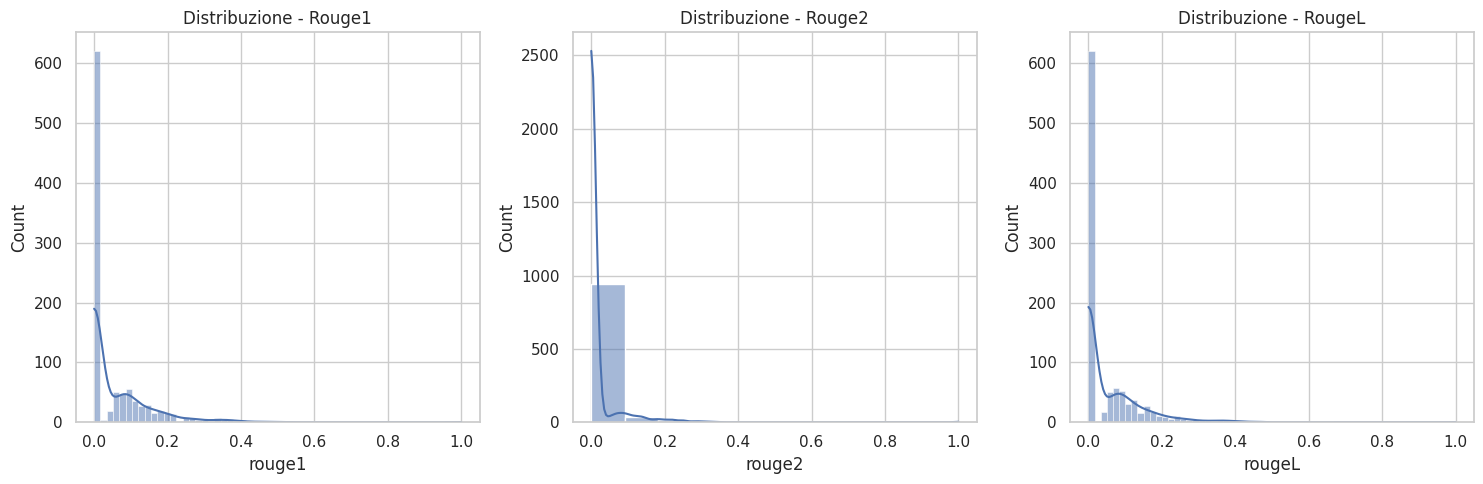

In [17]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.histplot(rouges_lsa["rouge1"], kde=True, ax=axes[0])
axes[0].set_title('Distribuzione - Rouge1')

sns.histplot(rouges_lsa["rouge2"], kde=True, ax=axes[1])
axes[1].set_title('Distribuzione - Rouge2')

sns.histplot(rouges_lsa["rougeL"], kde=True, ax=axes[2])
axes[2].set_title('Distribuzione - RougeL')

plt.tight_layout()

plt.show()

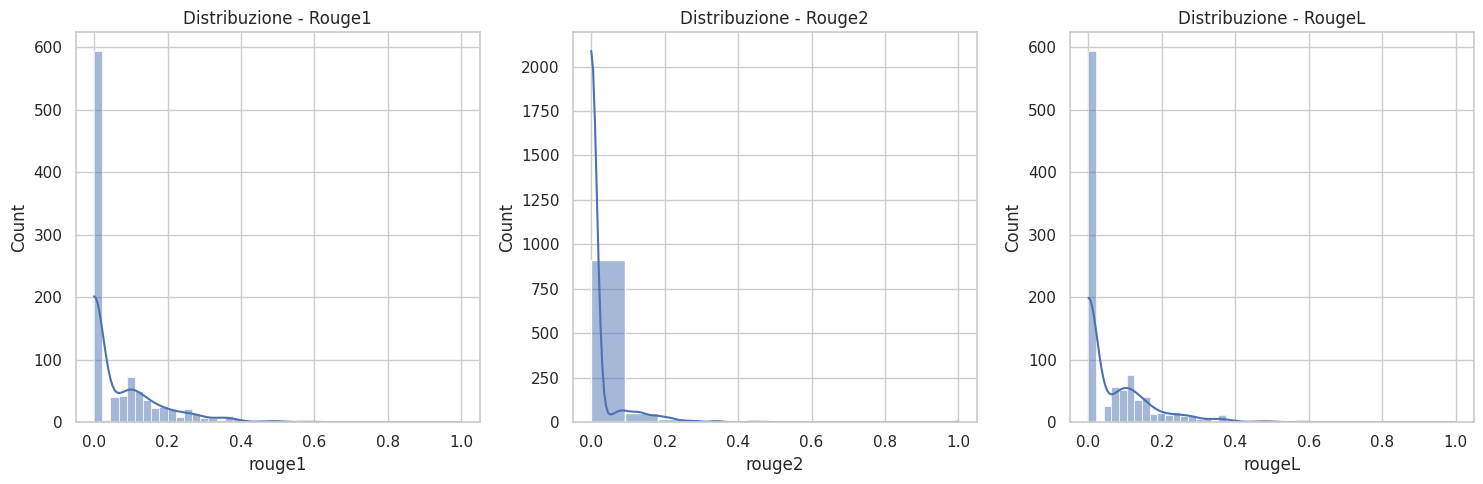

In [18]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.histplot(rouges_bert["rouge1"], kde=True, ax=axes[0])
axes[0].set_title('Distribuzione - Rouge1')

sns.histplot(rouges_bert["rouge2"], kde=True, ax=axes[1])
axes[1].set_title('Distribuzione - Rouge2')

sns.histplot(rouges_bert["rougeL"], kde=True, ax=axes[2])
axes[2].set_title('Distribuzione - RougeL')

plt.tight_layout()

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a1b052e0-2ae7-4808-9f70-51bfe2ee192f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>